# Get needed imports

In [1]:
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import keras
from keras import models
from keras import layers
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns

# Defining the Data class, which is used to hold the data for each of the different data split

In [2]:
class Data:
    
    # Constructor, with the text holding the updating text, and the labels containg the read labels
    def __init__(self, text, labels):
        self.text = text
        self.labels = labels

    # Function which is used to update the text
    def updateText(self, text):
        self.text = text

# Function for reading the data

In [3]:
# This function is responsible for reading the text and labels of a plit, and assigning it a 
# Data instance for the particular split

def readData(textFileName, labelsFileName):
    text = []
    labels = []

    with open(textFileName, 'r', encoding="utf-8") as textFile:
        for line in textFile:
            words = line.strip().split()
            text.append(words)

    with open(labelsFileName, 'r', encoding="utf-8") as labelsFile:
        for line in labelsFile:
            line = line.strip()
            labels.append(int(line))

    return Data(text,labels)

# Functions neede for cleaning the data

In [4]:
# This function converts every word into its lower case variant, removes the word if it is a stop word,
# stems the word if possible, and removes the # from hashtags, whil leaving the word

def cleanText(data, language):
    stopWords = stopwords.words(language)
    stemmer = SnowballStemmer(language)

    cleanText = []

    for text in data.text:
        cleanSentence = []

        for word in text:
            word = word.lower()

            if word[0] == '#':
                word = word[1:]

            if (word not in stopWords) & (word.isalpha()):
                cleanSentence.append(stemmer.stem(word))
        
        cleanText.append(cleanSentence)
    
    data.updateText(cleanText)
    
# This function is used for the train split, and gets every word and keeps the number of occurrences it has.
# If the number of occurrences is below the minimum, it is omitted, and the rest are added to the vocabulary.
# Each token in vocabulary is indexed, starting from 2, as to count for the future pad which will have the value of 0,
# and for the case that the word was never met before, which takes the value of 1

# This function return the indexes for use of the following function

def convertTokenIntoIndexTrain(data, minimum):
    vocabulary = {}

    for sentence in data.text:
        for token in sentence:
            if not token in vocabulary:
                vocabulary[token] = 1
            else:
                vocabulary[token] += 1
    
    vocabulary = {token:occurrences for token, occurrences in vocabulary.items() if occurrences >= minimum}
    
    indexes = {}

    indexes["UNKNOWN"] = 1 

    for index, token in enumerate(vocabulary, start=2):
        indexes[token] = index
    
    indexedText = [[indexes.get(token) for token in sentence] for sentence in data.text]
    indexedText = [[1 if index is None else index for index in sentence] for sentence in indexedText]

    data.updateText(indexedText)

    return indexes

# This function indexes the words found within the test and trail splits, based in the indexes produced from the train split

def convertTokenToIndexTestAndVal(data, indexes):
    indexedText = [[indexes.get(token) for token in sentence] for sentence in data.text]
    indexedText = [[1 if index is None else index for index in sentence] for sentence in indexedText]

    data.updateText(indexedText)
    
# This function converts the data into a NumPy array, and adds 0s to the end of the data rows that are shorter than
# the longest data row, in order to have an equal length for each data row, and help the neural network produce a better result

def padIndexedText(data):
    maximum = max([len(sentence) for sentence in data.text])
    dataPad = np.zeros([len(data.text), maximum], np.int32)
    
    for (i, row) in enumerate(data.text):
       dataPad[i,:len(row)] = row

    data.updateText(dataPad)

# Reading the Train, Test and Trial Data

In [5]:
# Set language to 'es' and 'full_language' to 'spanish' for spanish,
# and language to 'us' and 'full_language' to 'english' for english 
language = 'us'
full_language = 'english'

# Set bound to number of minimum of occurrences for a word to count towards the vocabulary
bound = 5

# Reading and Preprocessing of Train Split 
train_data = readData('train/'+language+'_train.text','train/'+language+'_train.labels')
cleanText(train_data, full_language)
indexes = convertTokenIntoIndexTrain(train_data, bound)
padIndexedText(train_data) 

# Reading and Preprocessing of Trial (Validation) Split 
val_data = readData('trial/'+language+'_trial.text','trial/'+language+'_trial.labels')
cleanText(val_data, full_language)
convertTokenToIndexTestAndVal(val_data, indexes)
padIndexedText(val_data) 

# Reading and Preprocessing of Test Split 
test_data = readData('test/'+language+'_test.text','test/'+language+'_test.labels')
cleanText(test_data, full_language)
convertTokenToIndexTestAndVal(test_data, indexes)
padIndexedText(test_data) 

# Building, Training and Saving the Neural Network

In [6]:
# Change sofmax_value to according to language (20 for US, 19 for ES)
softmax_value = 20

# Building the actual neural network
model = models.Sequential()
model.add(layers.Embedding(len(indexes)+1, 64, input_length=None, mask_zero=True))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.05))
model.add(layers.LSTM(64))
model.add(layers.Dropout(0.05))
model.add(layers.Dense(softmax_value, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Training the neural network
history = model.fit(train_data.text, keras.utils.to_categorical(train_data.labels), epochs=10, batch_size=256, validation_data=(val_data.text,keras.utils.to_categorical(val_data.labels)))

# Saving the neural network
model.save("models/"+language+"_model.h5")
print("Saved model to disk")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          1356224   
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          33024     
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                1300      
Total params: 1,423,572
Trainable params: 1,423,572
Non-trainable params: 0
______________________________________________

# Evaluation Script

In [7]:
# Official Evaluation Script
def f1(precision, recall):
    return (2.0*precision*recall)/(precision+recall)


def evaluation(gold, predict):

    truth_dict = {}
    output_dict_correct = {}
    output_dict_attempted = {}
    
    if len(predict) != len(gold):
        sys.exit('ERROR: Number of lines in gold and output files differ')
    for i in range(len(predict)):
        line = predict[i]
        emoji_code_gold = gold[i]
        
        if emoji_code_gold not in truth_dict:
            truth_dict[emoji_code_gold] = 1
        else: 
            truth_dict[emoji_code_gold] += 1

        emoji_code_output=predict[i]
        
        if emoji_code_output==emoji_code_gold:
            if emoji_code_output not in output_dict_correct: 
                output_dict_correct[emoji_code_gold] = 1
            else: 
                output_dict_correct[emoji_code_output] += 1
                
        if emoji_code_output not in output_dict_attempted: 
            output_dict_attempted[emoji_code_output] = 1
        else: 
            output_dict_attempted[emoji_code_output] += 1
    
    precision_total = 0
    recall_total = 0
    num_emojis = len(truth_dict)
    attempted_total = 0
    correct_total = 0
    gold_occurrences_total = 0
    f1_total = 0
    
    for emoji_code in truth_dict:
        gold_occurrences = truth_dict[emoji_code]
        
        if emoji_code in output_dict_attempted: 
            attempted = output_dict_attempted[emoji_code]
        else: 
            attempted = 0
            
        if emoji_code in output_dict_correct: 
            correct = output_dict_correct[emoji_code]
        else: 
            correct = 0
            
        if attempted != 0:
            precision = (correct*1.0)/attempted
            recall = (correct*1.0)/gold_occurrences
            
            if precision != 0.0 or recall != 0.0: 
                f1_total += f1(precision, recall)
                
        attempted_total += attempted
        correct_total += correct
        gold_occurrences_total += gold_occurrences
        
    macrof1 = f1_total/(num_emojis*1.0)
    precision_total_micro = (correct_total*1.0)/attempted_total
    recall_total_micro = (correct_total*1.0)/gold_occurrences_total
    
    if precision_total_micro != 0.0 or recall_total_micro != 0.0:
        microf1 = f1(precision_total_micro, recall_total_micro)
    else: 
        microf1 = 0.0
    
    print ("Macro F-Score (official): " + str(round(macrof1*100, 3)))
    print ("-----")
    print ("Micro F-Score: " + str(round(microf1*100, 3)))
    print ("Precision: " + str(round(precision_total_micro*100, 3)))
    print ("Recall: " + str(round(recall_total_micro*100, 3)))

# Load Model

In [8]:
# Only run in case of loading only file

# Set language to 'es' for spanish, and language to 'us' for english 
language = 'us'

# Reading and Preprocessing of Test Split for indexes
train_data = readData('train/'+language+'_train.text','train/'+language+'_train.labels')
cleanText(train_data, full_language)
indexes = convertTokenIntoIndexTrain(train_data, bound)

# Reading and Preprocessing of Test Split 
test_data = readData('test/'+language+'_test.text','test/'+language+'_test.labels')
cleanText(test_data, full_language)
convertTokenToIndexTestAndVal(test_data, indexes)
padIndexedText(test_data) 

model = models.load_model("models/"+language+"_model.h5")

# Evaluation and Confusion Matrix 

Macro F-Score (official): 20.414
-----
Micro F-Score: 30.342
Precision: 30.342
Recall: 30.342


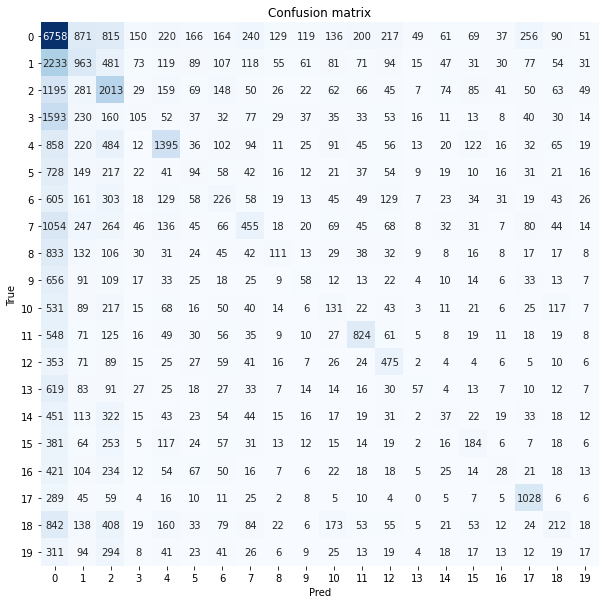

In [9]:
results = model.predict(test_data.text)

predicted = []
for result in results:
    predicted.append(np.argmax(result))

def confusionMatrix(test, predict):
    classes = np.unique(test)
    cm = metrics.confusion_matrix(test, predict)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

evaluation(test_data.labels, predicted)
    
confusionMatrix(test_data.labels, predicted)